# Notebook for selecting items + creating lists

NOTE: This notebook shows our reasoning process in how to select items for the familiarisation phase, how to distribute items over 3 disjoint lists, how to select control items that are the same for all lists and repeating items per list.

For a concise and reproducible implementation see `items_lists.py`.

In [1]:
# load packages
import pandas as pd
import numpy as np
import csv
import random
import os

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# define paths
mp_freq_path = '../../external_resources/MultiPic_with_frequencies.csv'
aoa_path = '../../external_resources/norms/Birchenough_2017.csv'
sentences_path = '../data/example_sentences.ods'

In [3]:
# define function to lowercase a string and remove umlauts
def remove_umlauts(string):
    """ Removes umlauts and ß and lowercases strings.
    Input:
        string: A string.
    Output:
        new_string: Same string in lowercase and without umlauts.
    """
    umlauts = {'ä':'ae','ö':'oe','ü':'ue','ß':'ss'}
    new_string = string.lower()
    for umlaut in umlauts:
        new_string = new_string.replace(umlaut, umlauts[umlaut])
    return new_string

In [4]:
# load databases
# MultiPic with frequencies
mp_freq_df = pd.read_csv(mp_freq_path)

# Birchenough et al. (2017)
aoa_df = pd.read_csv(aoa_path, encoding='latin_1', usecols=[0,4,5,6,7,8,9,10,11,12,13])
# lowercase words + remove umlauts to make it comparable to MultiPic vers. 1
for i in aoa_df.index:
    cleaned_string = remove_umlauts(aoa_df.loc[i,'Word'])
    aoa_df.loc[i,'Word'] = cleaned_string

# example senteces
sentences_df = pd.read_excel(sentences_path, engine='odf', usecols=[0,2], sheet_name='MultiPic')

Look at databases to confirm everything loaded correctly:

In [5]:
mp_freq_df

,ITEM,PICTURE,NAME1,H_INDEX,PERCENTAGE_MODAL_NAME,VISUAL_COMPLEXITY,SUBTLEX,lgSUBTLEX,Google00pm,lgGoogle00
0,1,PICTURE_1,maus,0.000000,100.000000,3.02,10.91,2.444,11.17323,4.830
1,2,PICTURE_2,reifen,1.163235,69.696970,2.67,15.75,2.603,7.10619,4.633
2,3,PICTURE_3,treppenstufe,1.426663,46.464646,1.89,NaN,NaN,NaN,NaN
3,4,PICTURE_4,altar,0.968778,77.319588,3.40,7.56,2.286,5.93453,4.555
4,5,PICTURE_5,schulter,0.862355,82.978723,2.01,22.52,2.758,12.59959,4.882
...,...,...,...,...,...,...,...,...,...,...
745,746,PICTURE_746,kegel,0.516599,90.721649,1.69,0.91,1.380,1.80303,4.038
746,747,PICTURE_747,badewanne,0.468996,90.000000,2.57,7.91,2.305,1.58503,3.982
747,748,PICTURE_748,muschel,1.102087,73.195876,3.25,1.61,1.623,0.91945,3.745
748,749,PICTURE_749,muelleimer,1.678743,50.000000,3.32,3.35,1.934,0.70227,3.628


In [6]:
aoa_df

,Word,RatperWord,AoAestimate,SD,min,max,unknown,AoALikert,SDLikert,minLikert,maxLikert
0,aal,21,6.43,2.27,3.0,11.0,0,3.48,1.17,2,6
1,aas,17,8.65,2.74,5.0,14.0,0,4.53,1.37,3,7
2,abbau,16,9.25,2.79,4.0,13.0,0,4.69,1.49,2,7
3,abbauen,17,7.71,3.74,2.0,15.0,0,3.94,1.85,1,7
4,abbild,27,9.37,2.68,3.0,14.0,0,4.93,1.41,2,7
...,...,...,...,...,...,...,...,...,...,...,...
3254,zwieback,20,3.25,1.29,1.0,5.0,0,1.90,0.72,1,3
3255,zwiebel,15,4.47,1.77,3.0,9.0,0,2.60,0.91,2,5
3256,zwist,15,10.53,2.85,7.0,16.0,1,5.33,1.23,4,7
3257,zylinder,24,7.54,3.13,3.0,17.0,0,3.92,1.38,2,7


In [7]:
sentences_df

,ITEM,EXAMPLE
0,1,Die Maus schnuppert am Käse.
1,2,Das Auto hat vier Reifen.
2,3,Ronja steigt die Treppenstufen hinauf.
3,4,Die Pfarrerin steht vor dem Altar.
4,5,Ronja legt sich ein Tuch um die Schultern.
...,...,...
745,746,Die Bowlingkugel trifft alle Kegel.
746,747,Im Bad steht eine Badewanne.
747,748,Am Strand liegt eine Muschel.
748,749,Der Mülleimer ist sehr voll.


As has been shown in previous database explorations (see `Exploring+Combininb_German_MultiPic.ipynb`), there are a number of duplicate items in the MultiPic corpus. Sometimes, the same noun is depicted by different pictures even though they refer to the same meaning, sometimes the noun is actually a homonym and therefore depicted by different pictures. 
We can determine which duplicates are homonymous or not based on the example sentences we created. In case a duplicate pair does not differ semantically, as a rule for consistency we will drop those duplicate rows which have a lower name agreement (i.e., that have a higher H index value). 

In [8]:
# save a list of item names that occur several times
rows = mp_freq_df[mp_freq_df.duplicated(subset=['NAME1'],keep=False)]
values = list(set(rows['NAME1'].values))

save_path = '../data/items_lists/'
os.makedirs(save_path, exist_ok=True)

with open(save_path+'item names occurring several times', 'w') as f:
    write = csv.writer(f, delimiter='\n')
    write.writerow(values)

In [9]:
# combine MultiPic with our example sentences
mp_freq_df = mp_freq_df.merge(sentences_df,how='outer', on='ITEM')

In [10]:
# find duplicate rows
# truly duplicate items share the same item name and example sentence
duplicate_rows = mp_freq_df[mp_freq_df.duplicated(subset=['NAME1', 'EXAMPLE'],keep=False)]
duplicate_values = set(duplicate_rows['NAME1'].values)

# iterate through duplicate values
for i in duplicate_values:
    # get corresponding dataframe entries
    entries = duplicate_rows[duplicate_rows['NAME1']==i]
    # find minimum within entries
    h_min = entries['H_INDEX'].min()
    # drop rows from dataframe if they don't have the minimum H index
    for i in entries.index:
        if entries.loc[i, 'H_INDEX'] != h_min:
            mp_freq_df.drop(index=i, inplace=True)

# reset index
mp_freq_df.reset_index(drop=True,inplace=True)

print(f'There are {len(duplicate_values)} truly duplicate values in the original dataframe.')
print('\nNew dataframe length:',len(mp_freq_df))

There are 35 truly duplicate values in the original dataframe.

New dataframe length: 715


In [11]:
mp_freq_df[mp_freq_df['NAME1']=='adler']

,ITEM,PICTURE,NAME1,H_INDEX,PERCENTAGE_MODAL_NAME,VISUAL_COMPLEXITY,SUBTLEX,lgSUBTLEX,Google00pm,lgGoogle00,EXAMPLE
672,703,PICTURE_703,adler,1.408986,76.767677,3.34,6.58,2.225,10.36369,4.797,Der Adler versorgt seine Nachkommen im Horst.


Inspired by Kupermann et al. (2012) we want to select items matched for frequency by dividing the total word list into 10 equally sized frequency bins and selecting a set amount of words per bin for each list.

Before we determine the frequency bins we'll first have a look at what the frequency ranges in our dataset are.

In [12]:
# basic information: NaN values, min, max
freq_col = mp_freq_df['lgSUBTLEX']
print('There are', freq_col.isna().sum(),
    'items without frequency information.',
    '\nOtherwise, log frequencies range from',
    freq_col.min(), 'to', freq_col.max())

There are 12 items without frequency information. 
Otherwise, log frequencies range from 0.301 to 4.544


In [13]:
# determine frequency bins; add to dataframe
mp_freq_df['freq bins'] = pd.qcut(freq_col,q=10,labels=False, precision=10)

In [14]:
mp_freq_df

,ITEM,PICTURE,NAME1,H_INDEX,PERCENTAGE_MODAL_NAME,VISUAL_COMPLEXITY,SUBTLEX,lgSUBTLEX,Google00pm,lgGoogle00,EXAMPLE,freq bins
0,1,PICTURE_1,maus,0.000000,100.000000,3.02,10.91,2.444,11.17323,4.830,Die Maus schnuppert am Käse.,6.0
1,2,PICTURE_2,reifen,1.163235,69.696970,2.67,15.75,2.603,7.10619,4.633,Das Auto hat vier Reifen.,7.0
2,3,PICTURE_3,treppenstufe,1.426663,46.464646,1.89,NaN,NaN,NaN,NaN,Ronja steigt die Treppenstufen hinauf.,NaN
3,4,PICTURE_4,altar,0.968778,77.319588,3.40,7.56,2.286,5.93453,4.555,Die Pfarrerin steht vor dem Altar.,5.0
4,5,PICTURE_5,schulter,0.862355,82.978723,2.01,22.52,2.758,12.59959,4.882,Ronja legt sich ein Tuch um die Schultern.,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
710,744,PICTURE_744,ring,0.532835,87.878788,2.17,49.33,3.098,12.36043,4.874,Das Ehepaar trägt Ringe.,8.0
711,745,PICTURE_745,brunnen,0.000000,100.000000,3.35,9.76,2.396,6.27401,4.579,Die Bäuerin holt Wasser aus dem tiefen Brunnen.,6.0
712,746,PICTURE_746,kegel,0.516599,90.721649,1.69,0.91,1.380,1.80303,4.038,Die Bowlingkugel trifft alle Kegel.,1.0
713,747,PICTURE_747,badewanne,0.468996,90.000000,2.57,7.91,2.305,1.58503,3.982,Im Bad steht eine Badewanne.,5.0


In [15]:
def visualise_bins(df_column, nr_bins, quantile=True):
    """
    Visualise bin thresholds and counts per bin.
    Input:
        df_column: dataframe column to base the cut on
        nr_bins: number of bins to cut into
        quantile: Bool. Whether to use quantile based cutting or not
    Output:
        results_table: dataframe serving as 'overview' table
    """
    if quantile:
        results, bin_edges = pd.qcut(df_column,
                                    nr_bins,labels=False,
                                    retbins=True)
    else:
        results, bin_edges = pd.cut(df_column,
                                    nr_bins,labels=False,
                                    retbins=True)
    counts = results.value_counts()
    results_table = pd.DataFrame(columns=['Lower edge', 'Upper edge', 'Counts'])
    for i in range(nr_bins):
        results_table.loc[i,'Lower edge'] = bin_edges[i]
        results_table.loc[i,'Upper edge'] = bin_edges[i+1]
        results_table.loc[i,'Counts'] = counts[i]
    return results_table

In [16]:
# visualise bin thresholds and counts per bin
print('Thresholds and counts per bin:')
visualise_bins(mp_freq_df['lgSUBTLEX'], 10)

Thresholds and counts per bin:


,Lower edge,Upper edge,Counts
0,0.301,1.255,72
1,1.255,1.58,73
2,1.58,1.7892,66
3,1.7892,2.0202,70
4,2.0202,2.199,72
5,2.199,2.3784,69
6,2.3784,2.5712,70
7,2.5712,2.8354,70
8,2.8354,3.1172,70
9,3.1172,4.544,71


Visualise the frequency distributions within the bins

<Axes: xlabel='lgSUBTLEX', ylabel='Count'>

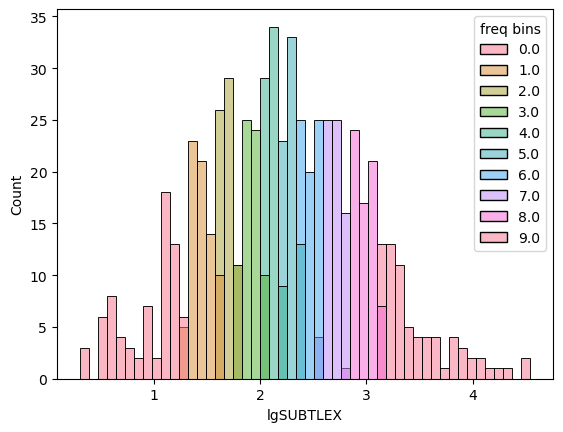

In [17]:
sns.histplot(data=mp_freq_df, x='lgSUBTLEX', hue='freq bins', bins=50, palette='husl')

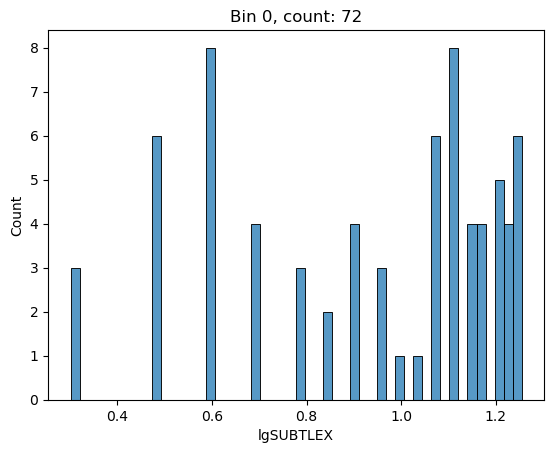

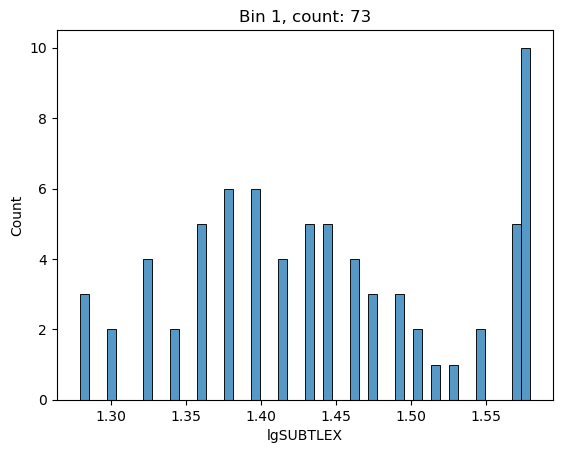

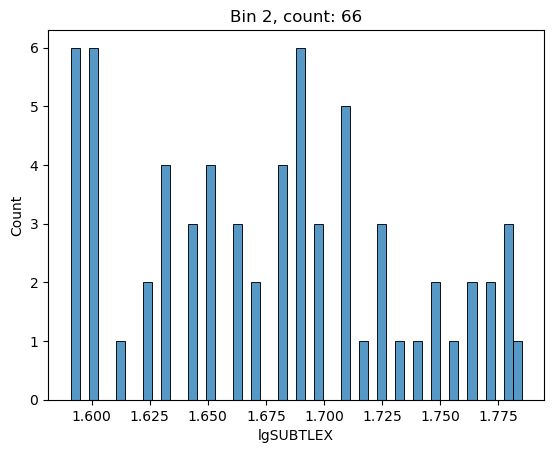

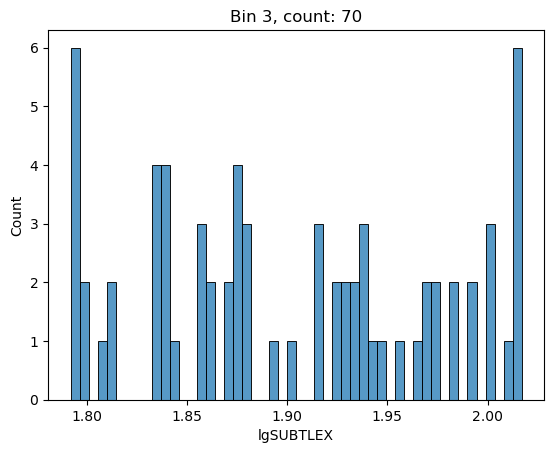

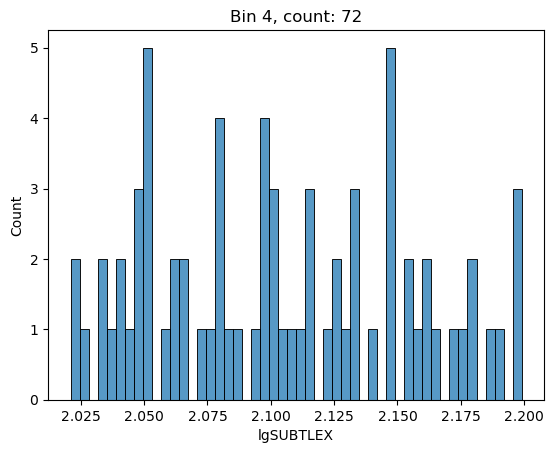

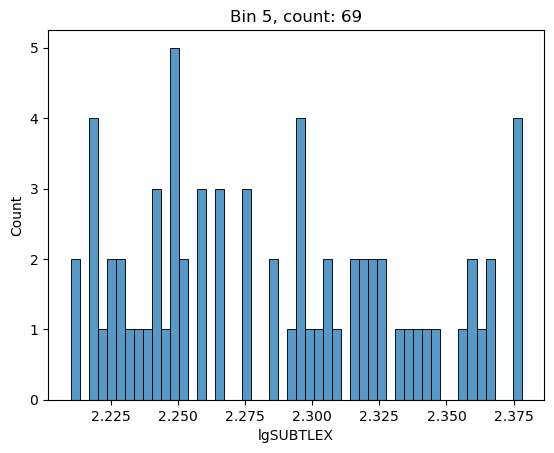

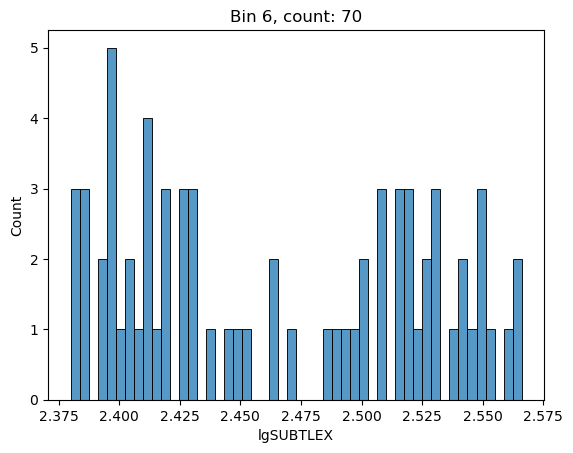

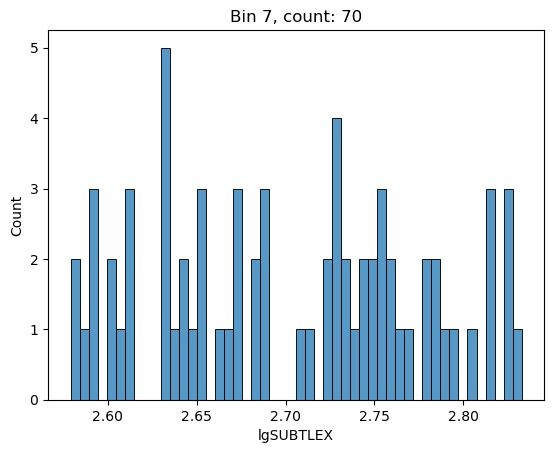

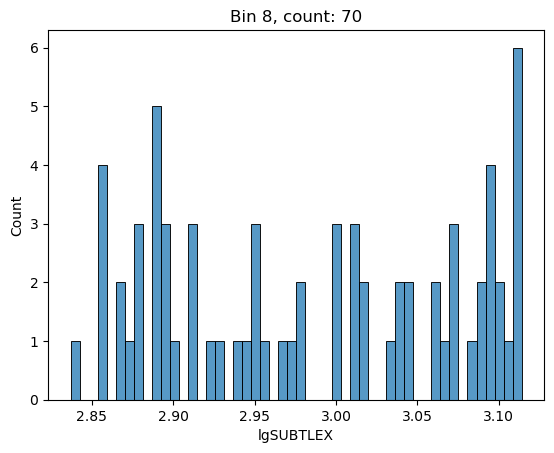

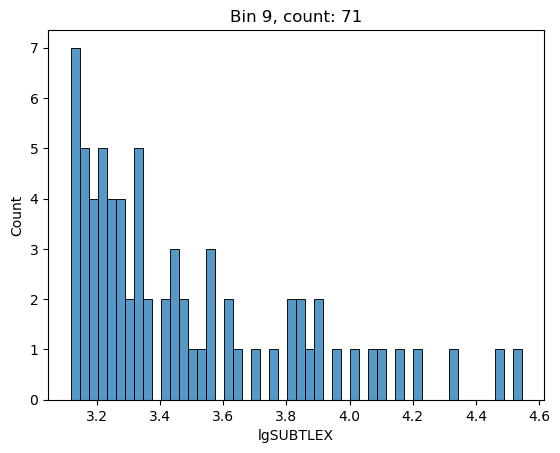

In [18]:
counts = mp_freq_df['freq bins'].value_counts()

for i in range(10):
    freq_bin = mp_freq_df[mp_freq_df['freq bins'] == i]
    plt.figure()
    sns.histplot(data=freq_bin, x='lgSUBTLEX', bins=50).set(title=f'Bin {i}, count: {counts[i]}')

## Selecting items from MultiPic for the lists
- 31 shared items
- 684 / 3 = 228 unique items for each of the three lists

In [19]:
shared_items_list = []
list_A = []
list_B = []
list_C = []

# set random seed
random.seed(43)

# set beginning of "leftover" iteration
add_to = 'A'

# iterate through the 10 frequency bins
for i in range(10): 
    freq_bin = mp_freq_df[mp_freq_df['freq bins'] == i]
    item_set = set(freq_bin['ITEM'])
    # check current lengths for lists
    print(f'A: {len(list_A)}, B: {len(list_B)}, C: {len(list_C)}')

    # in each bin, pick appropriate items for each category 

    # for shared items: draw 3 random items
    shared_items = random.sample(item_set, k=3)
    # append items to shared items list  
    shared_items_list += shared_items
    # remove drawn items from item pool
    item_set -= set(shared_items)

    # for different lists: divide remaining items from frequency bin
    # into 3 lists
    div_items = round(len(item_set)/3, 1)
    # print('div items:', div_items)
    # if cleanly divisible
    if str(div_items).endswith('0'):
        # print('Cleanly divisible')
        k = int(len(item_set)/3)
        # print('k:',k)
        # add same amount of items to all lists
        for l in [list_A, list_B, list_C]:
            # draw k random items
            list_items = random.sample(item_set, k=k)
            # append items to list
            l += list_items
            # remove drawn items from item pool
            item_set -= set(list_items)
    # if not cleanly divisible: make sure distribution 
    # will add up to 3 equally long lists in the end
    else:
        # print('Not cleanly divisible')
        # only distribute same amount of items for now 
        k = len(item_set)//3
        # print('k:',k)
        for l in [list_A, list_B, list_C]:
            # draw k random items
            list_items = random.sample(item_set, k=k)
            # append items to list
            l += list_items
            # remove drawn items from item pool
            item_set -= set(list_items)
        # assign "leftovers"
        while item_set:
            # draw one random item
            item = random.sample(item_set, k=1)
            # add item to one list in turn
            if add_to == 'A':
                list_A += item
                item_set -= set(item)
                add_to = 'B'
            elif add_to == 'B':
                list_B += item
                item_set -= set(item)
                add_to = 'C'
            elif add_to == 'C':
                list_C += item
                item_set -= set(item)
                add_to = 'A'
    
    # sanity check:
    print(f'Finished frequency bin {i}')
    if len(item_set) != 0:
        print(f'Something went wrong in frequency bin {i}, items still unassigned!')
        print(item_set)

# distribute items without frequency information, too!
print(f'A: {len(list_A)}, B: {len(list_B)}, C: {len(list_C)}')
nan_bin = mp_freq_df[freq_col.isna()==True]
nan_item_set = set(nan_bin['ITEM'])

# pick one item for the shared list, append
shared_item = random.sample(nan_item_set, k=1)
shared_items_list += shared_item
# remove drawn item from item pool
nan_item_set -= set(shared_item)

# pick items for individual lists, append
k = len(nan_item_set)//3
# add same amount of items to all lists
for l in [list_A, list_B, list_C]:
    # draw k random items
    list_items = random.sample(nan_item_set, k=k)
    # append items to list
    l += list_items
    # remove drawn items from item pool
    nan_item_set -= set(list_items)
# assign "leftovers" equally to lists
while nan_item_set:
    # draw one random item
    item = random.sample(nan_item_set, k=1)
    # add item to one list in turn
    if add_to == 'A':
        list_A += item
        nan_item_set -= set(item)
        add_to = 'B'
    elif add_to == 'B':
        list_B += item
        nan_item_set -= set(item)
        add_to = 'C'
    elif add_to == 'C':
        list_C += item
        nan_item_set -= set(item)
        add_to = 'A'
print('Finished NaN frequencies')
print(f'Final list lengths:\nA: {len(list_A)}, B: {len(list_B)}, C: {len(list_C)}')

A: 0, B: 0, C: 0
Finished frequency bin 0
A: 23, B: 23, C: 23
Finished frequency bin 1
A: 47, B: 46, C: 46
Finished frequency bin 2
A: 68, B: 67, C: 67
Finished frequency bin 3
A: 90, B: 90, C: 89
Finished frequency bin 4
A: 113, B: 113, C: 112
Finished frequency bin 5
A: 135, B: 135, C: 134
Finished frequency bin 6
A: 157, B: 157, C: 157
Finished frequency bin 7
A: 180, B: 179, C: 179
Finished frequency bin 8
A: 202, B: 202, C: 201
Finished frequency bin 9
A: 225, B: 224, C: 224
Finished NaN frequencies
Final list lengths:
A: 228, B: 228, C: 228


In [20]:
# save sorted lists to csv
for l in [list_A, list_B, list_C, shared_items_list]:
    l.sort()
np.savetxt(save_path+'list_A.csv', list_A, delimiter=', ', fmt='% i')
np.savetxt(save_path+'list_B.csv', list_B, delimiter=', ', fmt='% i')
np.savetxt(save_path+'list_C.csv', list_C, delimiter=', ', fmt='% i')
np.savetxt(save_path+'shared_items_list.csv', shared_items_list, delimiter=', ', fmt='% i')

## Selecting familiarisation items
- 10 items
- representing the whole range of AoA estimates
- not included in analysis; meant to familiarise participants with scale

In [8]:
# keep rows from Birchenough (2017) that are not in MultiPic
fam_df = aoa_df[~aoa_df['Word'].isin(mp_freq_df['NAME1'].values)]
fam_df.reset_index(drop=True, inplace=True)

# load cleaned SUBTLEX-DE dataset as dataframe, use word + spellcheck + lgSUBTLEX
subtlex_path = '../data/frequencies/SUBTLEX-DE_cleaned_with_Google00.txt'
subtlex_df = pd.read_csv(subtlex_path, sep='\t', decimal=',', encoding='latin_1', usecols=[0,2,4,5,8,9])

# get AoA values
fam_vals = set(fam_df['Word'].values)

# get SUBTLEX values
subtlex_vals = set(subtlex_df['Word'])
# make tokens comparable to MultiPic 
# by lowercasing + removing umlauts and ß
# create dict to map original to cleaned token
subtlex_vals_dict = dict()
for token in subtlex_vals:
    cleaned = remove_umlauts(token)
    # create new cleaned dict key if it doesn't exist yet
    if not cleaned in subtlex_vals_dict.keys():
        subtlex_vals_dict[cleaned] = []
    # map original to cleaned token
    subtlex_vals_dict[cleaned].append(token)
# create a set variable for easier calling
subtlex_vals_cleaned = set(subtlex_vals_dict.keys())

# combine AoA + frequency information
# prepare relevant SUBTLEX columns
fam_df = fam_df.reindex(columns=fam_df.columns.tolist()+['SUBTLEX','lgSUBTLEX','Google00pm','lgGoogle00'])
# fill frequency cells
for token in fam_vals:
    # check if token is present in SUBTLEX-DE
    if token in subtlex_vals_cleaned:
        # get correct row in SUBTLEX-DE
        index = 0
        # if there is more than one orthographic variant in SUBTLEX-DE
        if len(subtlex_vals_dict[token]) > 1:
            # check if entry 2 has correct spelling
            variant = subtlex_vals_dict[token][1]
            row = subtlex_df[(subtlex_df['Word'] == variant) & (subtlex_df['spell-check OK (1/0)'] == 1)]
            if len(row) > 0:
                # if yes, take note of index
                index = row.index[0]
        # else take row index from first variant
        variant = subtlex_vals_dict[token][0]
        index = subtlex_df[subtlex_df['Word'] == variant].index[0]

        # account for the fact that some names might occur more than once
        # add frequency information to combined_df
        indices = fam_df[fam_df['Word'] == token].index
        for i in range(len(indices)):
            fam_df.loc[indices[i], 'SUBTLEX'] = subtlex_df.loc[index, 'SUBTLEX']
            fam_df.loc[indices[i], 'lgSUBTLEX'] = subtlex_df.loc[index, 'lgSUBTLEX']
            fam_df.loc[indices[i], 'Google00pm'] = subtlex_df.loc[index, 'Google00pm']
            fam_df.loc[indices[i], 'lgGoogle00'] = subtlex_df.loc[index, 'lgGoogle00']

fam_df

,Word,RatperWord,AoAestimate,SD,min,max,unknown,AoALikert,SDLikert,minLikert,maxLikert,SUBTLEX,lgSUBTLEX,Google00pm,lgGoogle00
0,aal,21,6.43,2.27,3.0,11.0,0,3.48,1.17,2,6,1.10,1.462,0.57220,3.539
1,aas,17,8.65,2.74,5.0,14.0,0,4.53,1.37,3,7,1.14,1.477,1.33695,3.908
2,abbau,16,9.25,2.79,4.0,13.0,0,4.69,1.49,2,7,0.35,1.000,19.72644,5.077
3,abbauen,17,7.71,3.74,2.0,15.0,0,3.94,1.85,1,7,1.06,1.447,2.73323,4.218
4,abbild,27,9.37,2.68,3.0,14.0,0,4.93,1.41,2,7,2.72,1.845,7.81028,4.674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,zweifel,17,8.06,3.03,4.0,14.0,0,4.24,1.56,2,7,35.32,2.953,58.84595,5.551
2865,zwieback,20,3.25,1.29,1.0,5.0,0,1.90,0.72,1,3,0.39,1.041,0.29089,3.246
2866,zwist,15,10.53,2.85,7.0,16.0,1,5.33,1.23,4,7,0.28,0.903,0.66409,3.604
2867,zylinder,24,7.54,3.13,3.0,17.0,0,3.92,1.38,2,7,2.56,1.820,3.05585,4.267


Create 10 range bins based on AoA estimates:

In [22]:
# try out /visualise quantile based cut
print('Thresholds and counts per quantile bin:')
visualise_bins(fam_df['AoAestimate'], 10, quantile=True)

Thresholds and counts per quantile bin:


,Lower edge,Upper edge,Counts
0,1.67,4.06,288
1,4.06,4.94,288
2,4.94,5.74,287
3,5.74,6.46,289
4,6.46,7.21,286
5,7.21,7.88,288
6,7.88,8.71,288
7,8.71,9.584,281
8,9.584,10.83,288
9,10.83,15.83,286


In [23]:
# try out /visualise range based cut
print('Thresholds and counts per range bin:')
visualise_bins(fam_df['AoAestimate'], 10, quantile=False)

Thresholds and counts per range bin:


,Lower edge,Upper edge,Counts
0,1.65584,3.086,69
1,3.086,4.502,348
2,4.502,5.918,521
3,5.918,7.334,548
4,7.334,8.75,542
5,8.75,10.166,408
6,10.166,11.582,256
7,11.582,12.998,126
8,12.998,14.414,40
9,14.414,15.83,11


Splitting the data into 10 quantile bins results in many very narrow bin spans and few large bin spans. Even though splitting the data into 10 bins based on the given range leads to three bins with a small amount of item counts, it makes more sense to put emphasis on a most equally spaced age range representation.

In [11]:
# add age bins to dataframe
fam_df['AoA bins'] = pd.cut(fam_df['AoAestimate'],bins=10,labels=False, precision=10)

Visualise the word frequency distribution within the bins

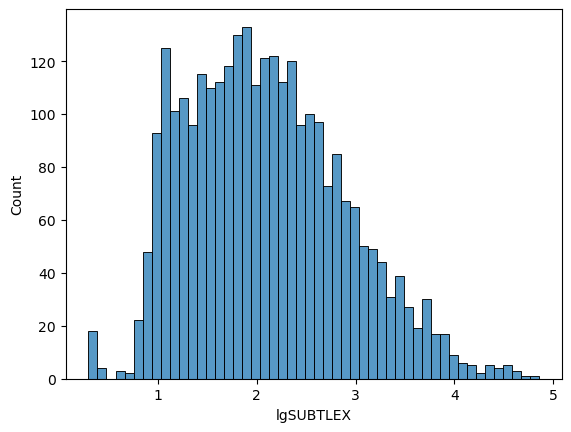

count    2869.000000
mean        2.090284
std         0.790415
min         0.301000
25%         1.477000
50%         2.021000
75%         2.607000
max         4.858000
Name: lgSUBTLEX, dtype: float64

In [25]:
sns.histplot(data=fam_df, x='lgSUBTLEX', bins=50)
plt.show()
fam_df['lgSUBTLEX'].describe()

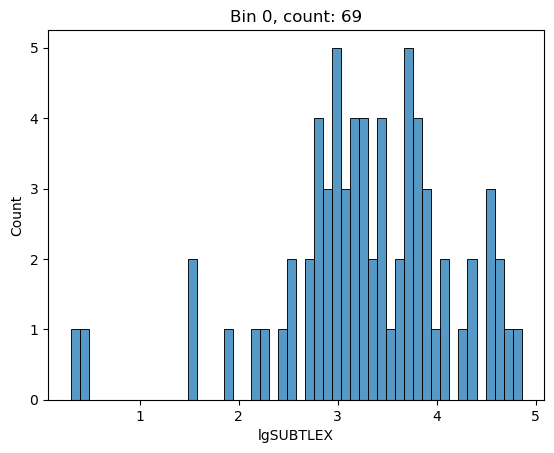

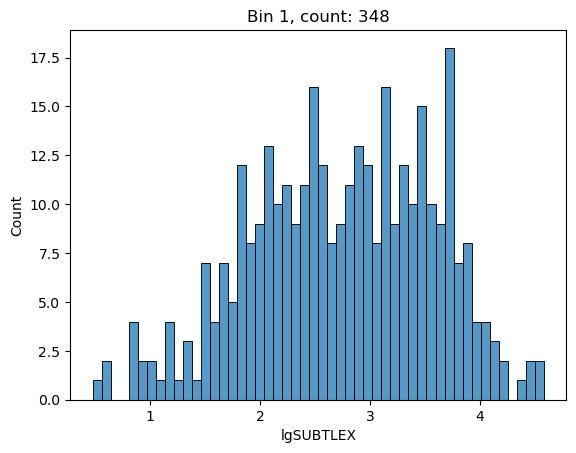

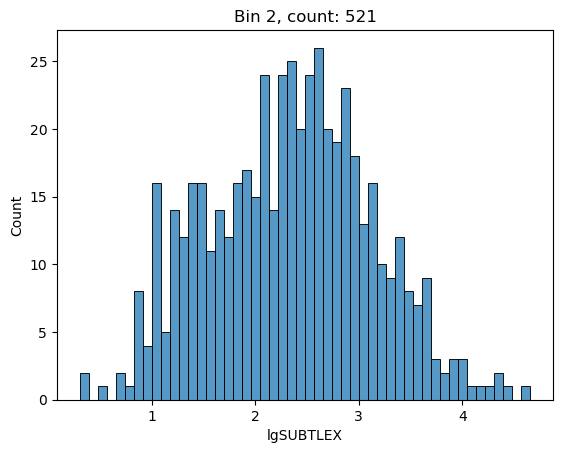

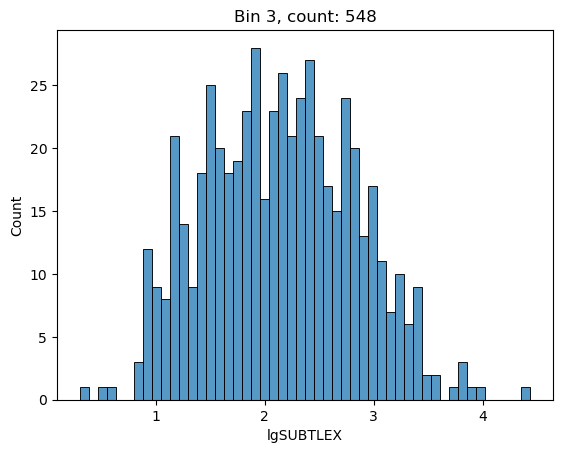

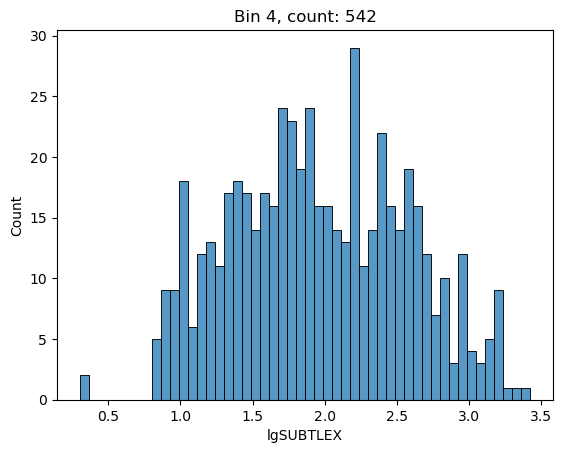

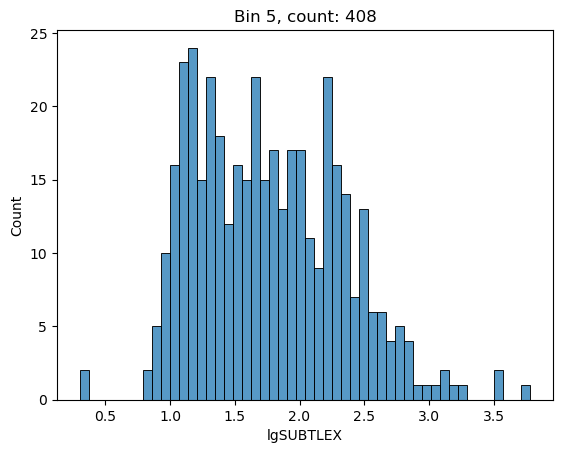

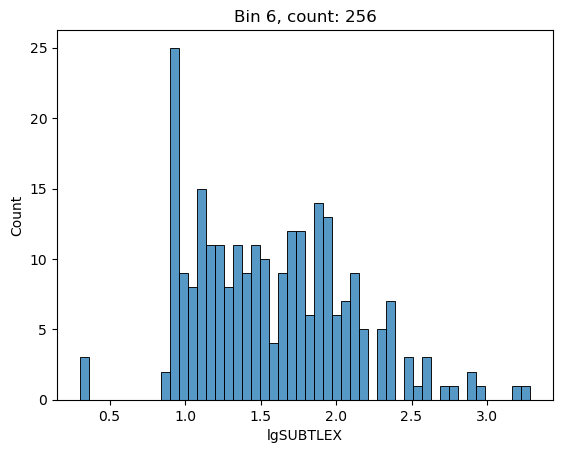

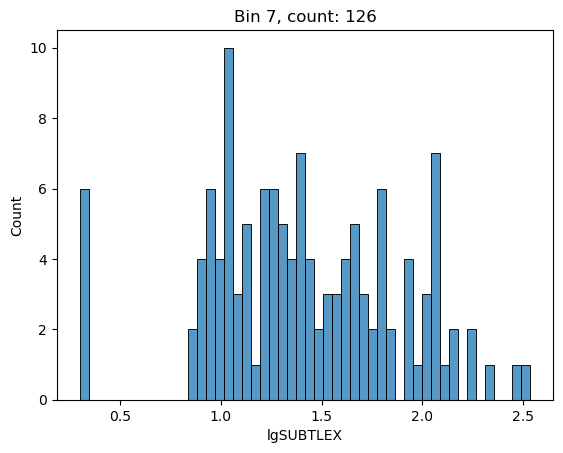

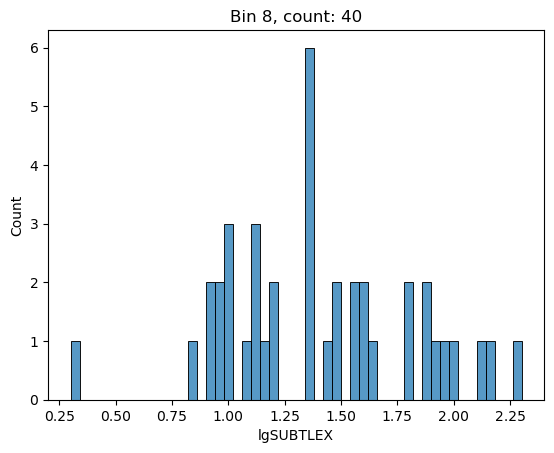

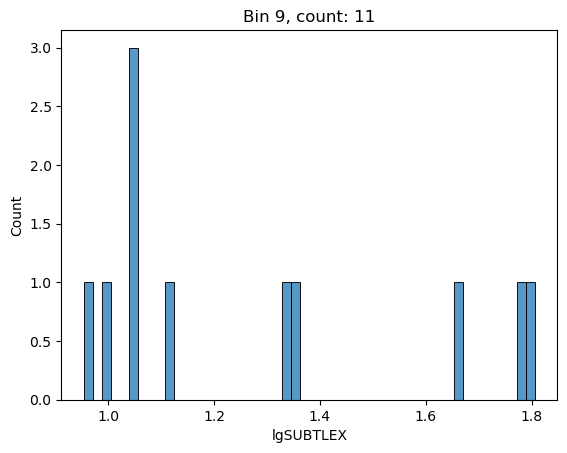

In [26]:
counts = fam_df['AoA bins'].value_counts()

for i in range(10):
    freq_bin = fam_df[fam_df['AoA bins'] == i]
    plt.figure()
    sns.histplot(data=freq_bin, x='lgSUBTLEX', bins=50).set(title=f'Bin {i}, count: {counts[i]}')

Looking at the individual frequency distributions within the bins reveals that all have items that lie within the standard deviation of the frequency distribution of ALL possible words.

The procedure will therefore be the following:
In each range bin, we will filter for possible candidates by limiting the coice to items that 
1. lie within one standard deviation from the mean of the entire lgSUBTLEX frequency distribution of all available words, 
2. have a comparably low standard deviation from the AoA estimate, 
3. are a noun, and
4. fit to the MultiPic items, i.e., are rather concrete than abstract.

Because Birchenough (2017) includes all kinds of word types, manual perusion of possible candidates is necessary in order to ensure a noun is picked as a familiarisation item.

In [12]:
# filter for fitting frequencies
mean = fam_df['lgSUBTLEX'].describe()['mean']
std = fam_df['lgSUBTLEX'].describe()['std']
min_freq = mean-std
max_freq = mean+std

fam_filtered = fam_df[(fam_df['lgSUBTLEX'] > min_freq) & (fam_df['lgSUBTLEX'] < max_freq)]

In [13]:
# manually change bin numbers to check out possible items
fam_filtered[fam_filtered['AoA bins'] == 0].sort_values(by=['SD','lgSUBTLEX']).head(20)

,Word,RatperWord,AoAestimate,SD,min,max,unknown,AoALikert,SDLikert,minLikert,maxLikert,SUBTLEX,lgSUBTLEX,Google00pm,lgGoogle00,AoA bins
256,becher,18,3.00,0.77,2.0,4.0,0,1.72,0.46,1,2,6.61,2.228,6.12823,4.569,0
1150,jacke,15,2.77,0.82,1.5,4.0,0,1.60,0.51,1,2,27.80,2.849,3.38740,4.312,0
999,gruen,19,2.95,0.85,2.0,5.0,0,1.74,0.56,1,3,25.83,2.818,15.04754,4.959,0
532,durst,23,2.70,0.88,1.0,4.0,0,1.61,0.50,1,2,14.21,2.559,3.76391,4.357,0
367,blau,17,2.76,0.90,1.0,4.0,0,1.71,0.47,1,2,26.85,2.834,12.82024,4.890,0
401,brei,14,2.50,0.94,1.0,4.0,0,1.50,0.52,1,2,5.28,2.130,1.69759,4.012,0
2717,waschen,18,2.67,0.97,1.0,4.0,0,1.56,0.51,1,2,22.21,2.752,6.27616,4.579,0
1436,lutscher,19,3.08,1.00,2.0,5.0,0,1.63,0.60,1,3,1.30,1.531,0.09074,2.740,0
2074,schaukeln,20,2.75,1.02,1.0,5.0,0,1.65,0.59,1,3,3.03,1.892,0.99515,3.780,0
408,brot,23,2.83,1.07,1.0,5.0,0,1.70,0.56,1,3,24.45,2.794,17.35170,5.021,0


Display the chosen items

In [14]:
fam_items = ['becher','reis','zeugnis','komma','kloster','solo','seuche','reaktor','hypothek','dozent']
final_fam_df = fam_df[fam_df['Word'].isin(fam_items)].sort_values(by=['AoA bins'])
final_fam_df

,Word,RatperWord,AoAestimate,SD,min,max,unknown,AoALikert,SDLikert,minLikert,maxLikert,SUBTLEX,lgSUBTLEX,Google00pm,lgGoogle00,AoA bins
256,becher,18,3.00,0.77,2.0,4.0,0,1.72,0.46,1,2,6.61,2.228,6.12823,4.569,0
1945,reis,25,3.72,1.02,2.0,6.0,0,2.08,0.57,1,3,17.76,2.655,5.01673,4.482,1
2826,zeugnis,10,5.70,0.95,5.0,8.0,0,3.10,0.32,3,4,4.53,2.064,16.95024,5.011,2
1261,komma,15,6.53,1.13,5.0,8.0,0,3.47,0.52,3,4,4.06,2.017,2.67852,4.210,3
1242,kloster,15,7.67,1.54,6.0,10.0,0,3.93,0.80,3,5,9.25,2.373,12.27052,4.871,4
2226,solo,14,9.93,1.73,7.0,12.0,0,5.21,0.80,4,6,6.54,2.223,4.43660,4.429,5
2178,seuche,14,10.29,2.05,7.0,14.0,0,5.43,1.02,4,7,3.15,1.908,1.58387,3.982,6
1911,reaktor,19,12.63,2.14,8.0,16.0,0,6.32,0.89,4,7,3.46,1.949,1.23546,3.874,7
1116,hypothek,19,13.21,2.37,8.0,16.0,0,6.37,0.96,4,7,3.58,1.964,2.63026,4.202,8
519,dozent,15,14.53,3.27,8.0,22.0,0,6.53,0.83,4,7,0.83,1.342,3.90473,4.373,9


In [16]:
# save!
save_path = '../AoA_items/'
final_fam_df.to_csv(save_path+'familiarisation_items_overview.csv', index=False)

## Select repeated items
- 25 within each of the 3 lists
- for determining within-participant consistency
- covering range of AoA estimates
- low estimate SD

In [21]:
# find items in Birchenough (2017) that are in MultiPic
rep_df = aoa_df.merge(mp_freq_df.rename(columns={'NAME1':'Word'}), on='Word')
rep_df.reset_index(drop=True, inplace=True)
print(f'There are {len(rep_df)} items with AoA estimate information.')

# load lists
list_A = np.loadtxt(save_path+'list_A.csv')
list_B = np.loadtxt(save_path+'list_B.csv')
list_C = np.loadtxt(save_path+'list_C.csv')

There are 397 items with AoA estimate information.


In [22]:
rep_df['AoAestimate'].describe()

count    397.000000
mean       4.551058
std        1.559659
min        2.150000
25%        3.380000
50%        4.220000
75%        5.410000
max       12.380000
Name: AoAestimate, dtype: float64

In [23]:
results, bin_edges = pd.cut(rep_df['AoAestimate'],
                                    10,labels=False,
                                    retbins=True)
print(results.value_counts())
print(bin_edges)

1    124
2     94
0     71
3     48
4     31
5     24
6      3
9      1
8      1
Name: AoAestimate, dtype: int64
[ 2.13977  3.173    4.196    5.219    6.242    7.265    8.288    9.311
 10.334   11.357   12.38   ]


In [24]:
results, bin_edges = pd.cut(rep_df['AoAestimate'],
                                    5,labels=False,
                                    retbins=True)
print(results.value_counts())
print(bin_edges)

0    195
1    142
2     55
3      3
4      2
Name: AoAestimate, dtype: int64
[ 2.13977  4.196    6.242    8.288   10.334   12.38   ]


In [25]:
results, bin_edges = pd.qcut(rep_df['AoAestimate'],
                                    5,labels=False,
                                    retbins=True)
print(results.value_counts())
print(bin_edges)

0    82
3    80
4    79
2    79
1    77
Name: AoAestimate, dtype: int64
[ 2.15   3.24   3.848  4.596  5.79  12.38 ]


In [26]:
# list A
print(rep_df[rep_df['ITEM'].isin(list_A)]['AoAestimate'].describe())
results, bin_edges = pd.cut(rep_df[rep_df['ITEM'].isin(list_A)]['AoAestimate'],
                                    5,labels=False,
                                    retbins=True)
print('\nBins + edges')
print(results.value_counts())
print(bin_edges)

count    126.000000
mean       4.592619
std        1.606238
min        2.290000
25%        3.295000
50%        4.155000
75%        5.775000
max        9.290000
Name: AoAestimate, dtype: float64

Bins + edges
0    49
1    36
2    21
3    14
4     6
Name: AoAestimate, dtype: int64
[2.283 3.69  5.09  6.49  7.89  9.29 ]


In [27]:
# list B
print(rep_df[rep_df['ITEM'].isin(list_B)]['AoAestimate'].describe())
results, bin_edges = pd.cut(rep_df[rep_df['ITEM'].isin(list_B)]['AoAestimate'],
                                    5,labels=False,
                                    retbins=True)

print(results.value_counts())
print(bin_edges)

count    135.000000
mean       4.687556
std        1.722707
min        2.150000
25%        3.405000
50%        4.380000
75%        5.635000
max       12.380000
Name: AoAestimate, dtype: float64
0    60
1    52
2    21
4     2
Name: AoAestimate, dtype: int64
[ 2.13977  4.196    6.242    8.288   10.334   12.38   ]


In [28]:
# list C
print(rep_df[rep_df['ITEM'].isin(list_C)]['AoAestimate'].describe())
results, bin_edges = pd.cut(rep_df[rep_df['ITEM'].isin(list_C)]['AoAestimate'],
                                    5,labels=False,
                                    retbins=True)
print('\nBins + edges')
print(results.value_counts())
print(bin_edges)

count    126.000000
mean       4.389127
std        1.333074
min        2.260000
25%        3.445000
50%        4.110000
75%        5.047500
max        8.680000
Name: AoAestimate, dtype: float64

Bins + edges
1    50
0    37
2    26
3     8
4     5
Name: AoAestimate, dtype: int64
[2.25358 3.544   4.828   6.112   7.396   8.68   ]


In [29]:
# check out AoA estimate SD
rep_df['SD'].describe()

count    397.000000
mean       1.879144
std        0.815725
min        0.830000
25%        1.300000
50%        1.650000
75%        2.250000
max        6.910000
Name: SD, dtype: float64

In [30]:
# limit df to items with relatively low SD
mean = rep_df['SD'].describe()['mean']
std = rep_df['SD'].describe()['std']
std_rep_df = rep_df[rep_df['SD'] < mean+std].copy()

print(len(std_rep_df[std_rep_df['ITEM'].isin(list_A)]))
print(len(std_rep_df[std_rep_df['ITEM'].isin(list_B)]))
print(len(std_rep_df[std_rep_df['ITEM'].isin(list_C)]))

104
111
114


In [31]:
results, bin_edges = pd.cut(std_rep_df['AoAestimate'],
                                    5,labels=False,
                                    retbins=True)
print(results.value_counts())
print(bin_edges)

1    135
0    107
2     63
3     25
4      9
Name: AoAestimate, dtype: int64
[2.14359 3.432   4.714   5.996   7.278   8.56   ]


In [32]:
# list A
std_rep_df[std_rep_df['ITEM'].isin(list_A)]['AoAestimate'].describe()

count    104.000000
mean       4.212115
std        1.382948
min        2.290000
25%        3.187500
50%        3.860000
75%        4.895000
max        8.560000
Name: AoAestimate, dtype: float64

In [33]:
# list B
std_rep_df[std_rep_df['ITEM'].isin(list_B)]['AoAestimate'].describe()

count    111.000000
mean       4.199009
std        1.254455
min        2.150000
25%        3.240000
50%        4.020000
75%        4.845000
max        7.780000
Name: AoAestimate, dtype: float64

In [34]:
# list C
std_rep_df[std_rep_df['ITEM'].isin(list_C)]['AoAestimate'].describe()

count    114.000000
mean       4.149298
std        1.083294
min        2.260000
25%        3.380000
50%        4.000000
75%        4.807500
max        7.570000
Name: AoAestimate, dtype: float64

In [35]:
# add a column of AoA bins to df
std_rep_df['AoA bins'] = pd.cut(std_rep_df['AoAestimate'],5,labels=False)

# overview of counts per bin per list
overview = pd.DataFrame()
column = 1
for l in [list_A, list_B, list_C]:
    counts = std_rep_df[std_rep_df['ITEM'].isin(l)]['AoA bins'].value_counts()
    for i in range(5):
        overview.loc[i, column] = counts[i]
    column += 1
overview = overview.rename(columns={1: 'list A', 2: 'list B', 3: 'list C'})
overview = overview.convert_dtypes()
overview

,list A,list B,list C
0,38,35,31
1,34,46,50
2,17,20,25
3,11,7,6
4,4,3,2


As can be seen, each list contains few counts in higher bins, but at least one item is present per bin.

Since the counts do not permit to draw 5 random items per bin, the following procedure will be applied instead:
First, one random item will be drawn from each bin for each list to ensure that the supported range is represented at all. Following that, 20 items will be drawn randomly from the entire pool of remaining items per list.

In [36]:
def select_repreated_items(items_list):
    random.seed(43)
    # prepare empty list for collection of repeated items
    selection = []
    # filter dataframe to items present in given list
    list_df = std_rep_df[std_rep_df['ITEM'].isin(items_list)]
    # set of items present in list
    all_items = set(list_df['ITEM'])

    # select one item from each bin
    for i in range(5):
        bin_items = set(list_df[list_df['AoA bins'] == i]['ITEM'])
        item = random.sample(bin_items,k=1)
        # append item to list
        selection += item
        # remove drawn item from list item pool
        all_items -= set(item)
    
    # draw further 20 items from remaining list item pool
    items = random.sample(all_items, k=20)
    # append items to list
    selection += items
    return selection

In [37]:
rep_A = select_repreated_items(list_A)
rep_B = select_repreated_items(list_B)
rep_C = select_repreated_items(list_C)

# overview of counts per bin per list
overview = pd.DataFrame()
column = 1
for r in [rep_A, rep_B, rep_C]:
    counts = std_rep_df[std_rep_df['ITEM'].isin(r)]['AoA bins'].value_counts()
    for i in range(5):
        overview.loc[i, column] = counts[i]
    column += 1
overview = overview.rename(columns={1: 'list A', 2: 'list B', 3: 'list C'})
overview = overview.convert_dtypes()
overview

,list A,list B,list C
0,9,8,8
1,7,7,12
2,3,4,3
3,3,5,1
4,3,1,1


In [38]:
# reminder bin edges:
bin_edges

array([2.14359, 3.432  , 4.714  , 5.996  , 7.278  , 8.56   ])

In [39]:
# sort lists
for l in [rep_A, rep_B, rep_C]:
    l.sort()
# save lists to csv
np.savetxt(save_path+'list_A_repeated.csv', rep_A, delimiter=', ', fmt='% i')
np.savetxt(save_path+'list_B_repeated.csv', rep_B, delimiter=', ', fmt='% i')
np.savetxt(save_path+'list_C_repeated.csv', rep_C, delimiter=', ', fmt='% i')